# Comprehensive EDA: Anomaly Detection Test Data

This notebook performs a detailed exploratory data analysis on the anomaly detection dataset containing:
- **Good samples**: Normal/defect-free images
- **Bad samples**: Images with anomalies/defects  
- **Masks**: Segmentation masks highlighting anomaly regions

Dataset collected between August-September 2024.

In [2]:
# Import required libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from pathlib import Path
import cv2
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# Set style for better visualizations
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (15, 8)
plt.rcParams['font.size'] = 10

# Define paths
base_path = r'anomaly_detection_test_data\anomaly_detection_test_data'
good_path = os.path.join(base_path, 'good')
bad_path = os.path.join(base_path, 'bad')
mask_path = os.path.join(base_path, 'masks')

print("✅ Libraries imported successfully!")
print(f"Base path: {base_path}")

✅ Libraries imported successfully!
Base path: anomaly_detection_test_data\anomaly_detection_test_data


## 1. Dataset Overview & File Structure

In [3]:
# Get all file lists
good_files = sorted([f for f in os.listdir(good_path) if f.endswith(('.png', '.jpg', '.jpeg'))])
bad_files = sorted([f for f in os.listdir(bad_path) if f.endswith(('.png', '.jpg', '.jpeg'))])
mask_files = sorted([f for f in os.listdir(mask_path) if f.endswith(('.png', '.jpg', '.jpeg'))])

# Dataset summary
dataset_info = {
    'Category': ['Good Samples', 'Bad Samples', 'Masks'],
    'Count': [len(good_files), len(bad_files), len(mask_files)]
}

df_summary = pd.DataFrame(dataset_info)

print("=" * 60)
print("DATASET SUMMARY")
print("=" * 60)
print(df_summary.to_string(index=False))
print("\n" + "=" * 60)

# Calculate class balance
total = len(good_files) + len(bad_files)
good_ratio = (len(good_files) / total) * 100
bad_ratio = (len(bad_files) / total) * 100

print(f"\n📊 Class Distribution:")
print(f"   Good samples: {len(good_files)} ({good_ratio:.2f}%)")
print(f"   Bad samples:  {len(bad_files)} ({bad_ratio:.2f}%)")
print(f"   Total:        {total}")

# Check if masks match bad samples
print(f"\n🔍 Mask-Bad Sample Alignment:")
print(f"   Masks available: {len(mask_files)}")
print(f"   Bad samples:     {len(bad_files)}")
print(f"   Match: {'✅ Yes' if len(mask_files) == len(bad_files) else '❌ No'}")


# Bar plot for dataset summary
sns.barplot(x='Category', y='Count', data=df_summary, palette='Set2')
plt.title('Dataset Category Counts')
plt.ylabel('Number of Files')
plt.xlabel('Category')
plt.show()


FileNotFoundError: [WinError 3] The system cannot find the path specified: 'anomaly_detection_test_data\\anomaly_detection_test_data\\good'

In [3]:
# Analyze filename patterns and timestamps
import re
from datetime import datetime

def parse_filename(filename):
    """Extract timestamp and file type from filename"""
    # Pattern: DD_MM_YYYY_HH_MM_SS.microseconds_type.png
    pattern = r'(\d{2})_(\d{2})_(\d{4})_(\d{2})_(\d{2})_(\d{2})\.(\d+)_(.*)\.(png|jpg)'
    match = re.match(pattern, filename)
    if match:
        day, month, year, hour, minute, second, microsec, file_type, ext = match.groups()
        timestamp = f"{year}-{month}-{day} {hour}:{minute}:{second}"
        return timestamp, file_type, ext
    return None, None, None

# Parse all filenames
good_timestamps = [parse_filename(f)[0] for f in good_files if parse_filename(f)[0]]
bad_timestamps = [parse_filename(f)[0] for f in bad_files if parse_filename(f)[0]]

print("📅 Temporal Information:")
print(f"\nGood samples date range:")
if good_timestamps:
    print(f"   First: {min(good_timestamps)}")
    print(f"   Last:  {max(good_timestamps)}")
    
print(f"\nBad samples date range:")
if bad_timestamps:
    print(f"   First: {min(bad_timestamps)}")
    print(f"   Last:  {max(bad_timestamps)}")

# Count file types
good_types = [parse_filename(f)[1] for f in good_files if parse_filename(f)[1]]
bad_types = [parse_filename(f)[1] for f in bad_files if parse_filename(f)[1]]

good_type_counts = Counter(good_types)
bad_type_counts = Counter(bad_types)

print(f"\n🏷️  File Type Distribution:")
print(f"\nGood samples:")
for ftype, count in good_type_counts.most_common():
    print(f"   {ftype}: {count}")
    
print(f"\nBad samples:")
for ftype, count in bad_type_counts.most_common():
    print(f"   {ftype}: {count}")

📅 Temporal Information:

Good samples date range:
   First: 2024-08-03 16:55:00
   Last:  2024-10-14 13:08:13

Bad samples date range:
   First: 2024-08-03 16:54:38
   Last:  2024-09-23 12:21:36

🏷️  File Type Distribution:

Good samples:
   cls_input: 2237
   classifier_input: 1770
   classifier_input.png: 3
   classifier_input (1): 1

Bad samples:
   cls_input: 260
   classifier_input: 208


## 2. Image Properties Analysis

In [4]:
# Load and analyze image dimensions, file sizes, and formats
def analyze_images(file_list, folder_path, sample_size=100):
    """Analyze image properties from a sample"""
    np.random.seed(42)
    sample_files = np.random.choice(file_list, min(sample_size, len(file_list)), replace=False)
    
    properties = {
        'width': [],
        'height': [],
        'channels': [],
        'file_size_kb': [],
        'mode': [],
        'aspect_ratio': []
    }
    
    for file in sample_files:
        try:
            img_path = os.path.join(folder_path, file)
            img = Image.open(img_path)
            img_array = np.array(img)
            
            properties['width'].append(img.width)
            properties['height'].append(img.height)
            properties['channels'].append(img_array.shape[2] if len(img_array.shape) == 3 else 1)
            properties['file_size_kb'].append(os.path.getsize(img_path) / 1024)
            properties['mode'].append(img.mode)
            properties['aspect_ratio'].append(img.width / img.height)
            
        except Exception as e:
            print(f"Error processing {file}: {e}")
    
    return properties

print("🔍 Analyzing image properties (sampling 100 images from each category)...\n")

# Analyze good images
good_props = analyze_images(good_files, good_path)
bad_props = analyze_images(bad_files, bad_path)
mask_props = analyze_images(mask_files, mask_path)

# Create summary dataframe
def summarize_properties(props, category):
    summary = {
        'Category': category,
        'Avg Width': np.mean(props['width']),
        'Avg Height': np.mean(props['height']),
        'Avg Channels': np.mean(props['channels']),
        'Avg File Size (KB)': np.mean(props['file_size_kb']),
        'Unique Modes': len(set(props['mode'])),
        'Avg Aspect Ratio': np.mean(props['aspect_ratio'])
    }
    return summary

summaries = [
    summarize_properties(good_props, 'Good'),
    summarize_properties(bad_props, 'Bad'),
    summarize_properties(mask_props, 'Mask')
]

df_props = pd.DataFrame(summaries)
print("=" * 100)
print("IMAGE PROPERTIES SUMMARY")
print("=" * 100)
print(df_props.to_string(index=False))
print("\n" + "=" * 100)

🔍 Analyzing image properties (sampling 100 images from each category)...

IMAGE PROPERTIES SUMMARY
Category  Avg Width  Avg Height  Avg Channels  Avg File Size (KB)  Unique Modes  Avg Aspect Ratio
    Good     286.12      141.38           3.0           43.640527             1          2.266895
     Bad     258.62      184.81           3.0           41.045742             1          1.741810
    Mask     258.62      184.81           1.0            0.547637             2          1.741810

IMAGE PROPERTIES SUMMARY
Category  Avg Width  Avg Height  Avg Channels  Avg File Size (KB)  Unique Modes  Avg Aspect Ratio
    Good     286.12      141.38           3.0           43.640527             1          2.266895
     Bad     258.62      184.81           3.0           41.045742             1          1.741810
    Mask     258.62      184.81           1.0            0.547637             2          1.741810



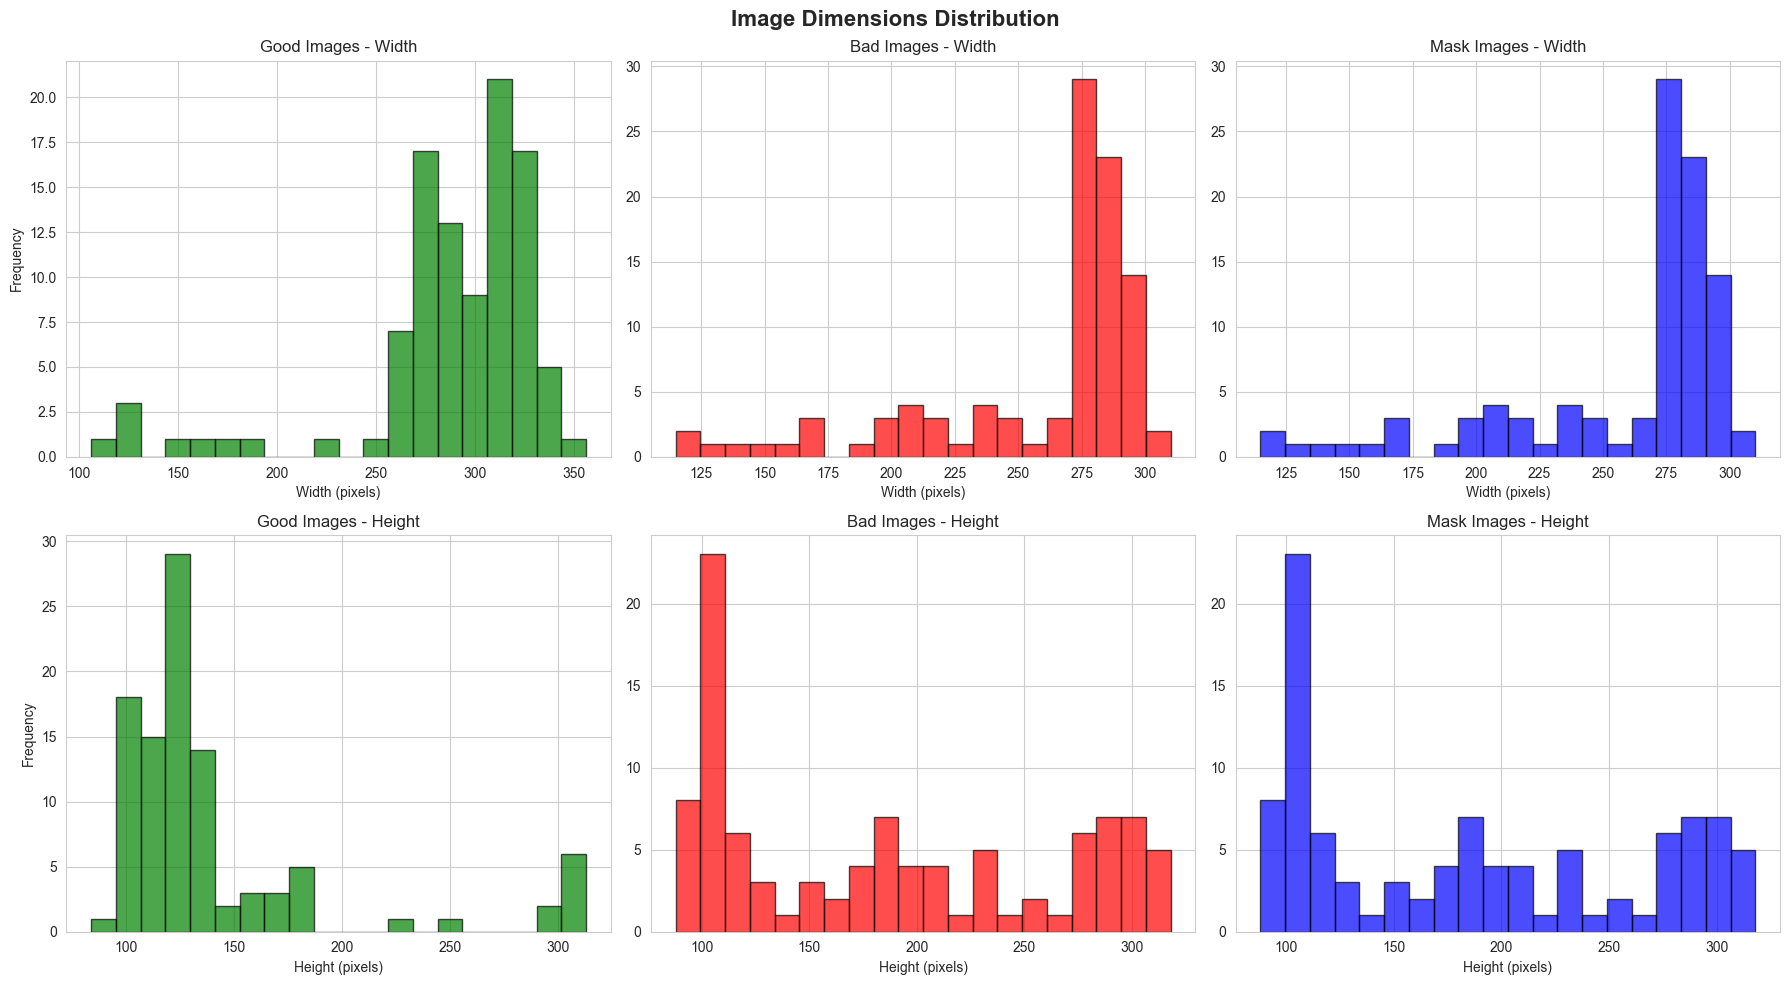


📦 File Size Statistics:

Good images: 43.64 KB (avg), 22.18 - 100.01 KB (range)
Bad images:  41.05 KB (avg), 20.16 - 54.90 KB (range)
Mask images: 0.55 KB (avg), 0.23 - 1.26 KB (range)


In [5]:
# Detailed dimension analysis
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Image Dimensions Distribution', fontsize=16, fontweight='bold')

# Width distributions
axes[0, 0].hist(good_props['width'], bins=20, color='green', alpha=0.7, edgecolor='black')
axes[0, 0].set_title('Good Images - Width')
axes[0, 0].set_xlabel('Width (pixels)')
axes[0, 0].set_ylabel('Frequency')

axes[0, 1].hist(bad_props['width'], bins=20, color='red', alpha=0.7, edgecolor='black')
axes[0, 1].set_title('Bad Images - Width')
axes[0, 1].set_xlabel('Width (pixels)')

axes[0, 2].hist(mask_props['width'], bins=20, color='blue', alpha=0.7, edgecolor='black')
axes[0, 2].set_title('Mask Images - Width')
axes[0, 2].set_xlabel('Width (pixels)')

# Height distributions
axes[1, 0].hist(good_props['height'], bins=20, color='green', alpha=0.7, edgecolor='black')
axes[1, 0].set_title('Good Images - Height')
axes[1, 0].set_xlabel('Height (pixels)')
axes[1, 0].set_ylabel('Frequency')

axes[1, 1].hist(bad_props['height'], bins=20, color='red', alpha=0.7, edgecolor='black')
axes[1, 1].set_title('Bad Images - Height')
axes[1, 1].set_xlabel('Height (pixels)')

axes[1, 2].hist(mask_props['height'], bins=20, color='blue', alpha=0.7, edgecolor='black')
axes[1, 2].set_title('Mask Images - Height')
axes[1, 2].set_xlabel('Height (pixels)')

plt.tight_layout()
plt.show()

# File size analysis
print("\n📦 File Size Statistics:")
print(f"\nGood images: {np.mean(good_props['file_size_kb']):.2f} KB (avg), "
      f"{np.min(good_props['file_size_kb']):.2f} - {np.max(good_props['file_size_kb']):.2f} KB (range)")
print(f"Bad images:  {np.mean(bad_props['file_size_kb']):.2f} KB (avg), "
      f"{np.min(bad_props['file_size_kb']):.2f} - {np.max(bad_props['file_size_kb']):.2f} KB (range)")
print(f"Mask images: {np.mean(mask_props['file_size_kb']):.2f} KB (avg), "
      f"{np.min(mask_props['file_size_kb']):.2f} - {np.max(mask_props['file_size_kb']):.2f} KB (range)")

## 3. Visual Inspection - Sample Images

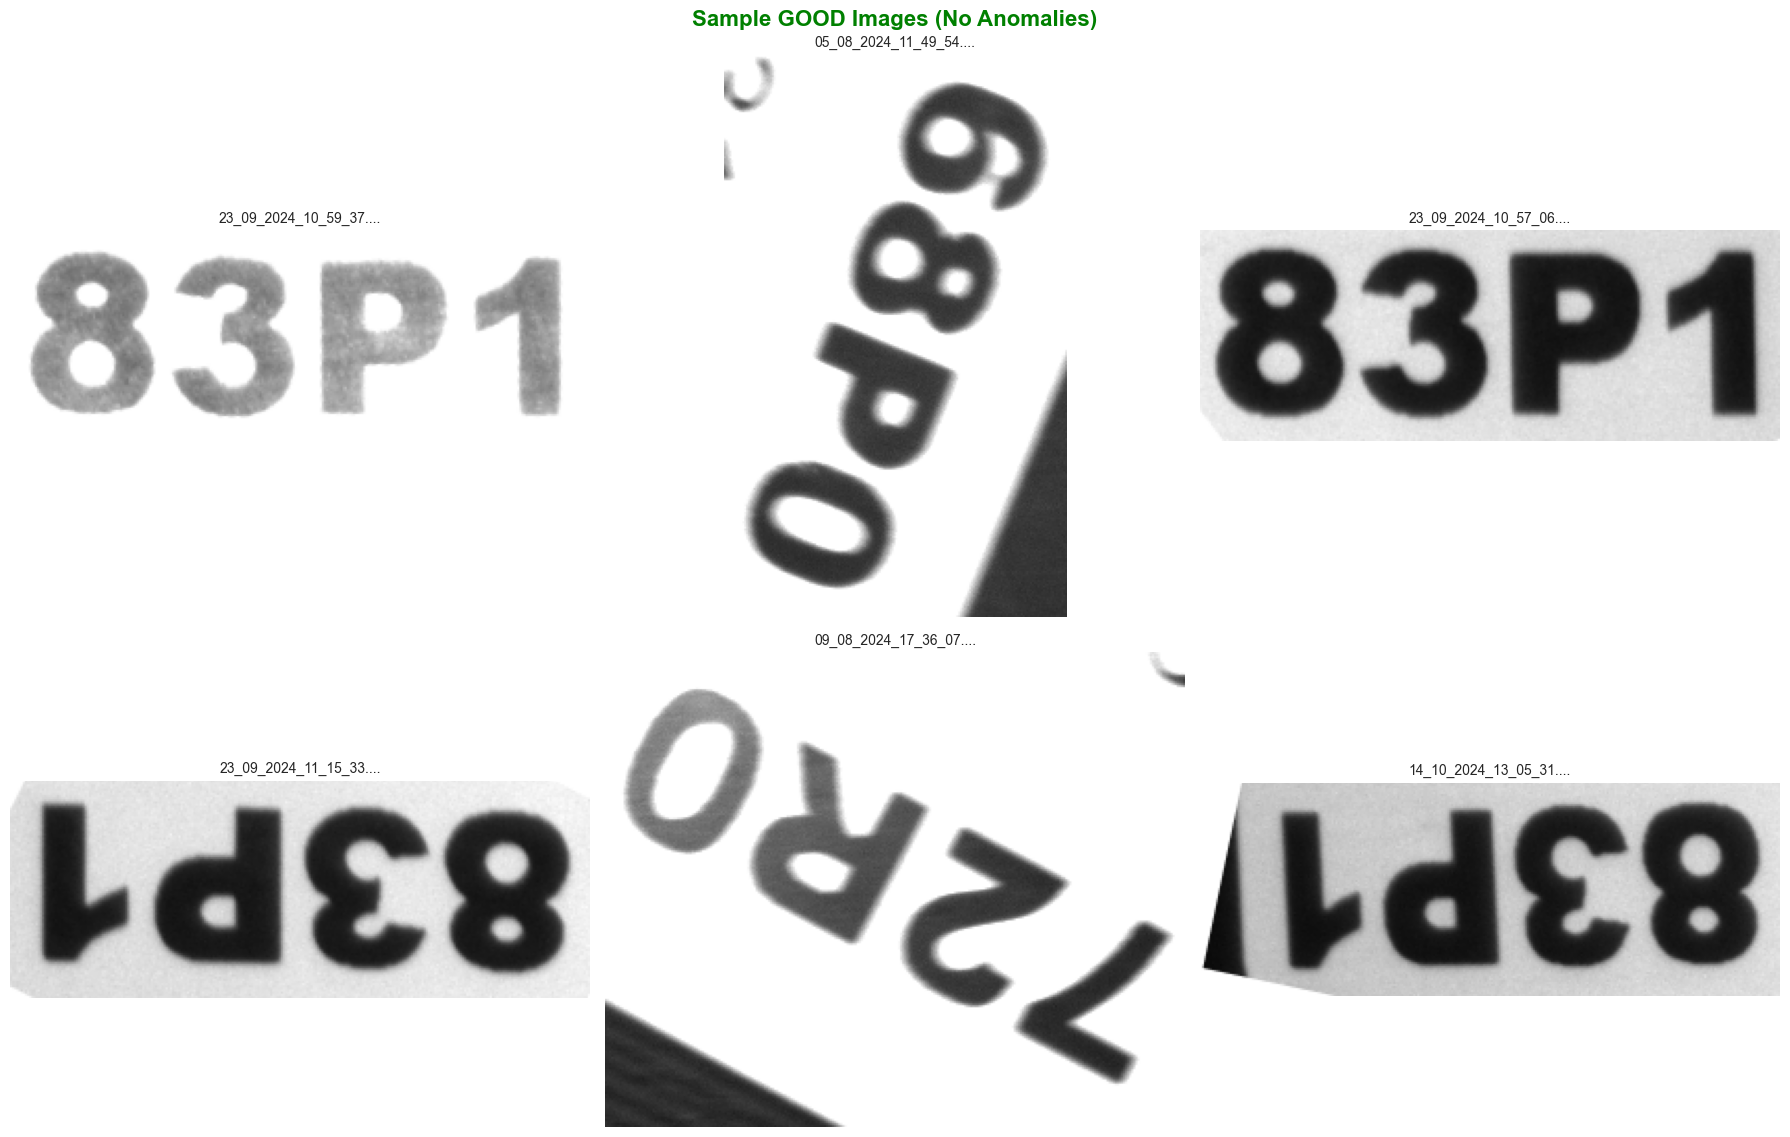

In [6]:
# Display sample good images
n_samples = 6
np.random.seed(42)
sample_good = np.random.choice(good_files, n_samples, replace=False)

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Sample GOOD Images (No Anomalies)', fontsize=16, fontweight='bold', color='green')

for idx, file in enumerate(sample_good):
    img = Image.open(os.path.join(good_path, file))
    ax = axes[idx // 3, idx % 3]
    ax.imshow(img)
    ax.set_title(f'{file[:20]}...', fontsize=10)
    ax.axis('off')

plt.tight_layout()
plt.show()

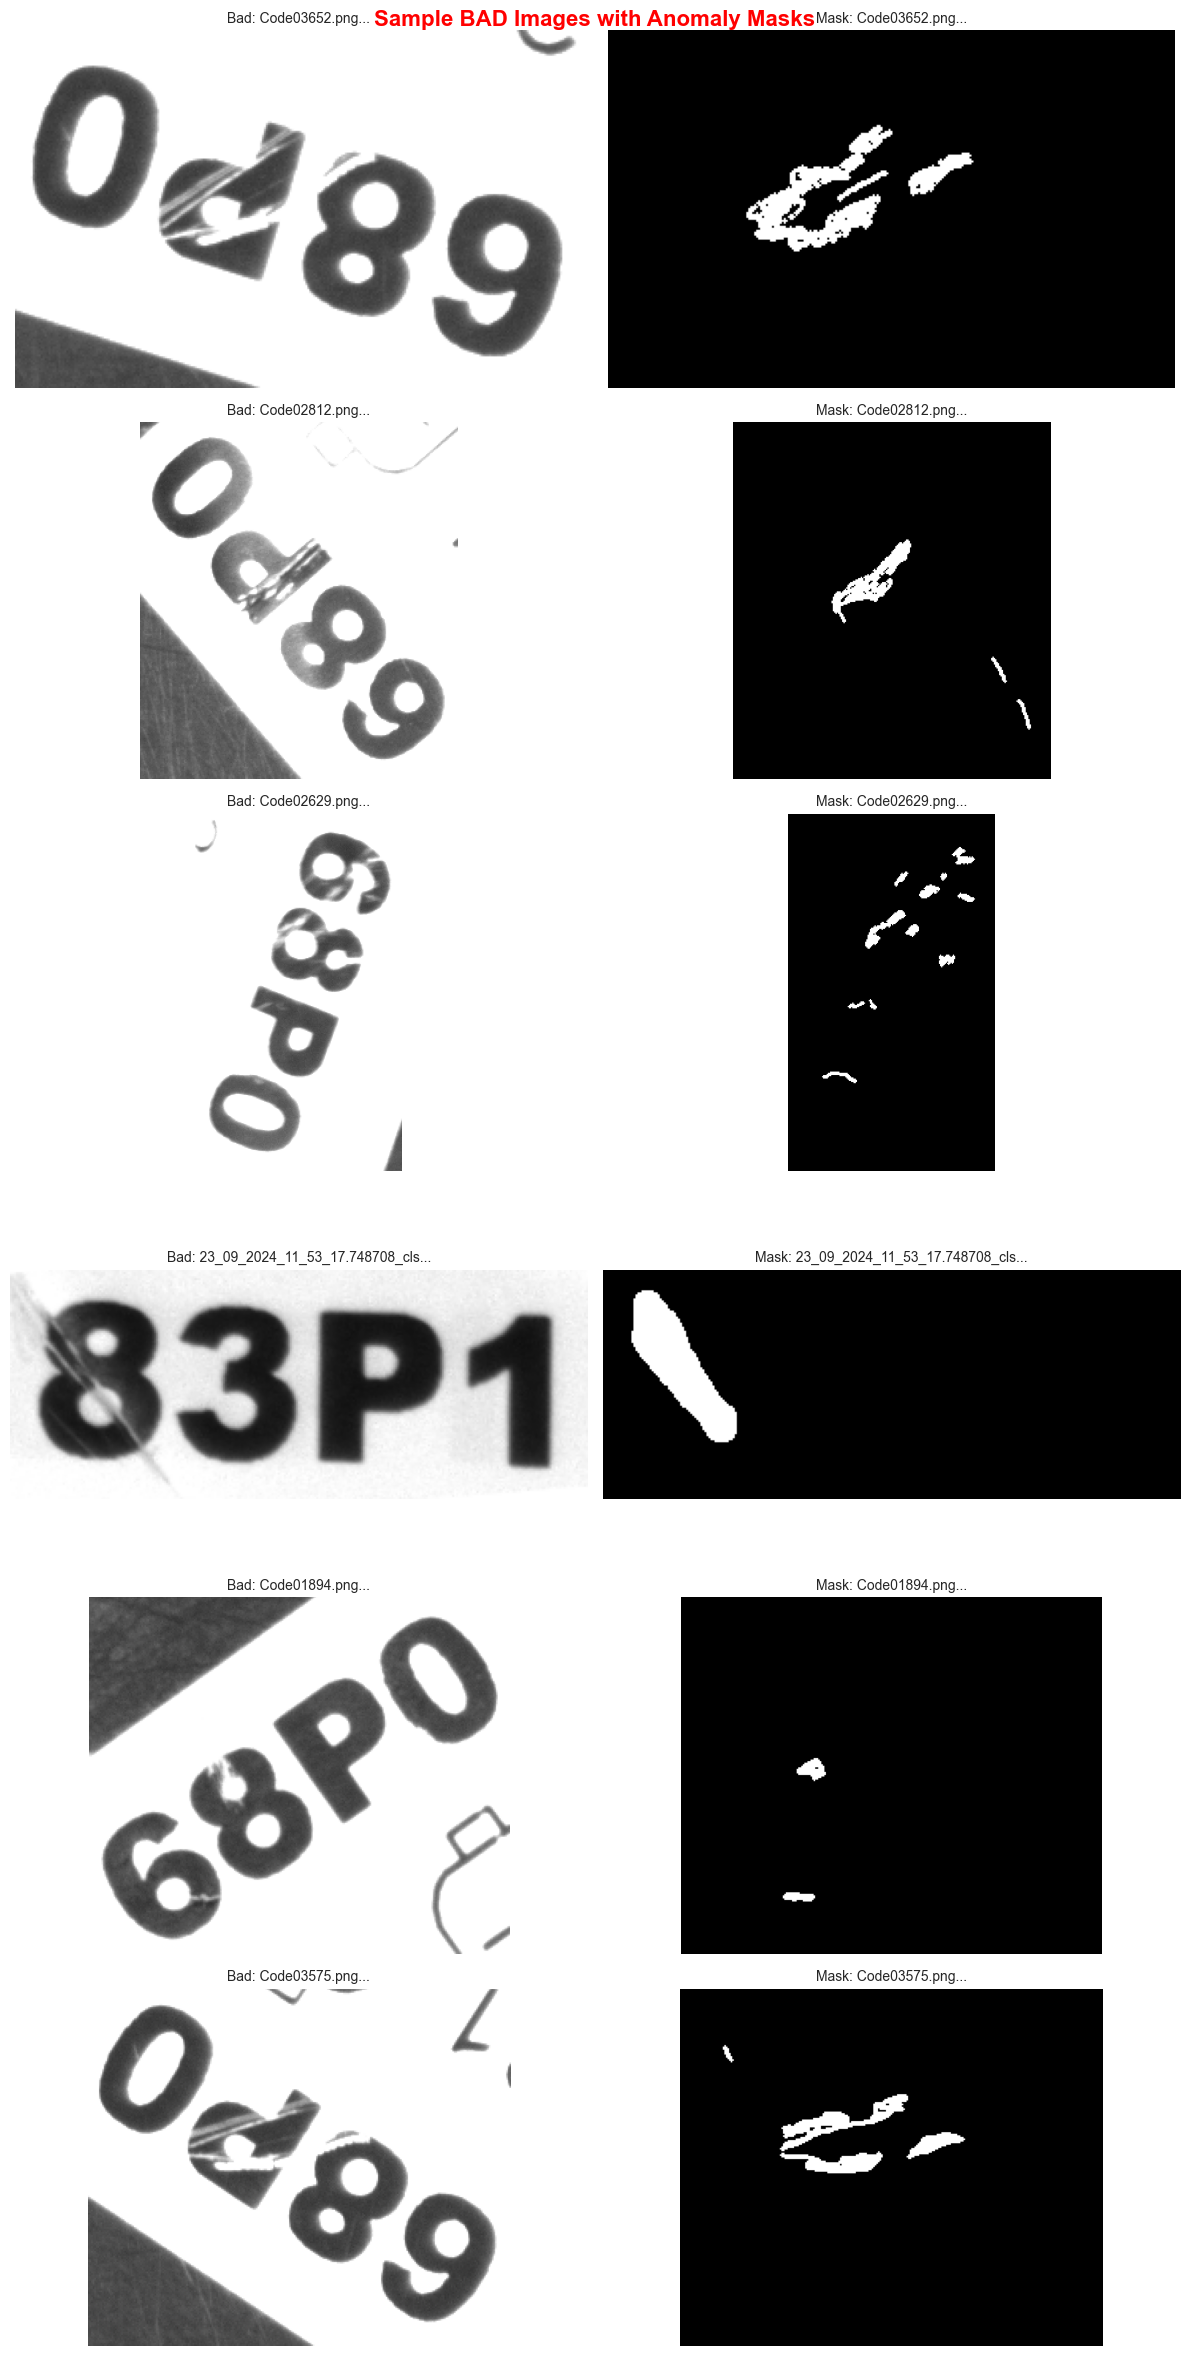

In [7]:
# Display sample bad images with corresponding masks
sample_bad = np.random.choice(bad_files, n_samples, replace=False)

fig, axes = plt.subplots(n_samples, 2, figsize=(12, 4*n_samples))
fig.suptitle('Sample BAD Images with Anomaly Masks', fontsize=16, fontweight='bold', color='red')

for idx, file in enumerate(sample_bad):
    # Bad image
    bad_img = Image.open(os.path.join(bad_path, file))
    axes[idx, 0].imshow(bad_img)
    axes[idx, 0].set_title(f'Bad: {file[:30]}...', fontsize=10)
    axes[idx, 0].axis('off')
    
    # Corresponding mask
    if file in mask_files:
        mask_img = Image.open(os.path.join(mask_path, file))
        axes[idx, 1].imshow(mask_img, cmap='gray')
        axes[idx, 1].set_title(f'Mask: {file[:30]}...', fontsize=10)
    else:
        axes[idx, 1].text(0.5, 0.5, 'No mask found', ha='center', va='center')
        axes[idx, 1].set_title('Mask not available')
    axes[idx, 1].axis('off')

plt.tight_layout()
plt.show()

## 4. Pixel Intensity Analysis

In [8]:
# Analyze pixel intensity statistics
def compute_intensity_stats(file_list, folder_path, sample_size=50):
    """Compute pixel intensity statistics"""
    np.random.seed(42)
    sample_files = np.random.choice(file_list, min(sample_size, len(file_list)), replace=False)
    
    means, stds, mins, maxs = [], [], [], []
    
    for file in sample_files:
        img = cv2.imread(os.path.join(folder_path, file))
        if img is not None:
            if len(img.shape) == 3:
                img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            else:
                img_gray = img
                
            means.append(np.mean(img_gray))
            stds.append(np.std(img_gray))
            mins.append(np.min(img_gray))
            maxs.append(np.max(img_gray))
    
    return {
        'mean': means,
        'std': stds,
        'min': mins,
        'max': maxs
    }

print("🎨 Computing pixel intensity statistics...\n")

good_intensity = compute_intensity_stats(good_files, good_path)
bad_intensity = compute_intensity_stats(bad_files, bad_path)
mask_intensity = compute_intensity_stats(mask_files, mask_path)

# Create comparison dataframe
intensity_comparison = pd.DataFrame({
    'Category': ['Good', 'Bad', 'Mask'],
    'Avg Mean Intensity': [
        np.mean(good_intensity['mean']),
        np.mean(bad_intensity['mean']),
        np.mean(mask_intensity['mean'])
    ],
    'Avg Std Dev': [
        np.mean(good_intensity['std']),
        np.mean(bad_intensity['std']),
        np.mean(mask_intensity['std'])
    ],
    'Avg Min': [
        np.mean(good_intensity['min']),
        np.mean(bad_intensity['min']),
        np.mean(mask_intensity['min'])
    ],
    'Avg Max': [
        np.mean(good_intensity['max']),
        np.mean(bad_intensity['max']),
        np.mean(mask_intensity['max'])
    ]
})

print("=" * 90)
print("PIXEL INTENSITY STATISTICS")
print("=" * 90)
print(intensity_comparison.to_string(index=False))
print("\n" + "=" * 90)

🎨 Computing pixel intensity statistics...

PIXEL INTENSITY STATISTICS
Category  Avg Mean Intensity  Avg Std Dev  Avg Min  Avg Max
    Good          184.330874    82.387121    32.48   254.38
     Bad          189.809759    82.492632    38.52   255.00
    Mask           11.036720    46.818513     0.00   255.00



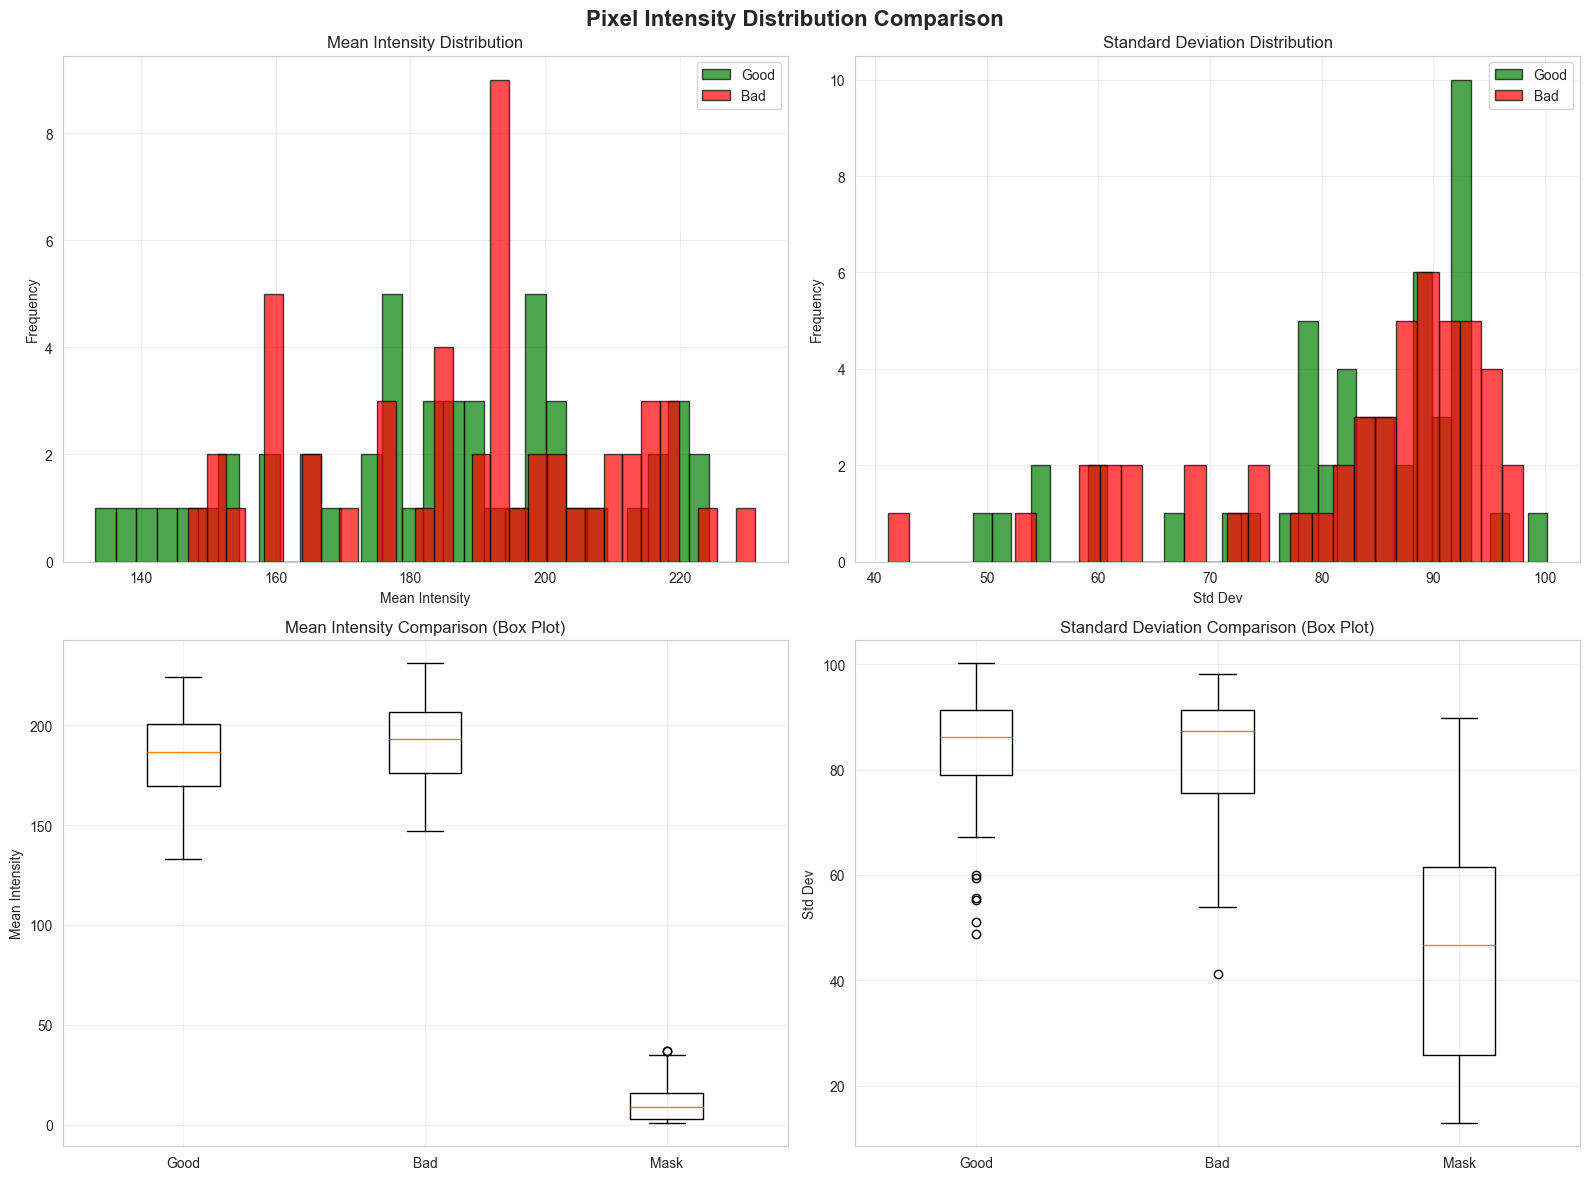

In [9]:
# Visualize intensity distributions
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Pixel Intensity Distribution Comparison', fontsize=16, fontweight='bold')

# Mean intensity
axes[0, 0].hist(good_intensity['mean'], bins=30, alpha=0.7, label='Good', color='green', edgecolor='black')
axes[0, 0].hist(bad_intensity['mean'], bins=30, alpha=0.7, label='Bad', color='red', edgecolor='black')
axes[0, 0].set_title('Mean Intensity Distribution')
axes[0, 0].set_xlabel('Mean Intensity')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# Standard deviation
axes[0, 1].hist(good_intensity['std'], bins=30, alpha=0.7, label='Good', color='green', edgecolor='black')
axes[0, 1].hist(bad_intensity['std'], bins=30, alpha=0.7, label='Bad', color='red', edgecolor='black')
axes[0, 1].set_title('Standard Deviation Distribution')
axes[0, 1].set_xlabel('Std Dev')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)

# Box plot comparison - Mean
data_mean = [good_intensity['mean'], bad_intensity['mean'], mask_intensity['mean']]
axes[1, 0].boxplot(data_mean, labels=['Good', 'Bad', 'Mask'])
axes[1, 0].set_title('Mean Intensity Comparison (Box Plot)')
axes[1, 0].set_ylabel('Mean Intensity')
axes[1, 0].grid(alpha=0.3)

# Box plot comparison - Std Dev
data_std = [good_intensity['std'], bad_intensity['std'], mask_intensity['std']]
axes[1, 1].boxplot(data_std, labels=['Good', 'Bad', 'Mask'])
axes[1, 1].set_title('Standard Deviation Comparison (Box Plot)')
axes[1, 1].set_ylabel('Std Dev')
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

## 5. Color Distribution Analysis

🌈 Analyzing color distributions...



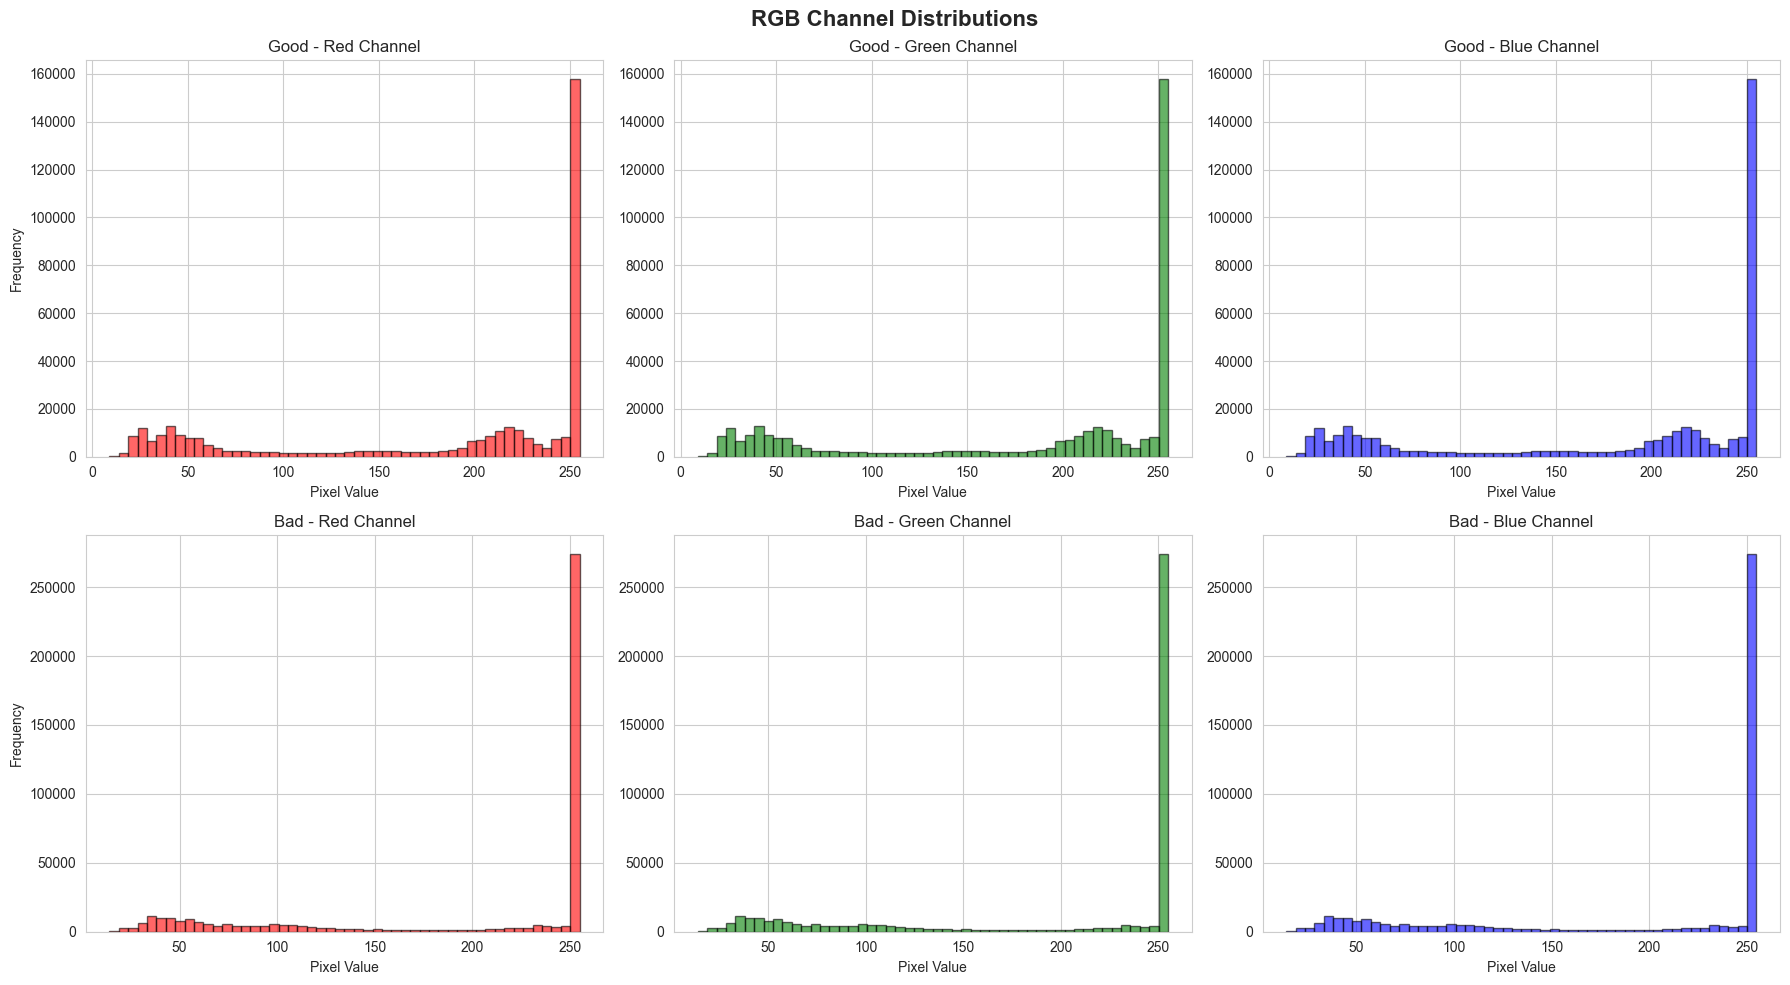


📊 RGB Channel Statistics:

Good Images:
   R channel - Mean: 183.48, Std: 86.78
   G channel - Mean: 183.48, Std: 86.78
   B channel - Mean: 183.48, Std: 86.78

Bad Images:
   R channel - Mean: 195.77, Std: 85.02
   G channel - Mean: 195.77, Std: 85.02
   B channel - Mean: 195.77, Std: 85.02


In [10]:
# Analyze RGB channel distributions
def analyze_color_channels(file_list, folder_path, n_samples=10):
    """Analyze RGB channel distributions"""
    np.random.seed(42)
    sample_files = np.random.choice(file_list, min(n_samples, len(file_list)), replace=False)
    
    r_vals, g_vals, b_vals = [], [], []
    
    for file in sample_files:
        img = cv2.imread(os.path.join(folder_path, file))
        if img is not None and len(img.shape) == 3:
            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            r_vals.extend(img_rgb[:,:,0].flatten())
            g_vals.extend(img_rgb[:,:,1].flatten())
            b_vals.extend(img_rgb[:,:,2].flatten())
    
    return r_vals, g_vals, b_vals

print("🌈 Analyzing color distributions...\n")

# Analyze good and bad images
good_r, good_g, good_b = analyze_color_channels(good_files, good_path)
bad_r, bad_g, bad_b = analyze_color_channels(bad_files, bad_path)

# Plot RGB distributions
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('RGB Channel Distributions', fontsize=16, fontweight='bold')

# Good images
axes[0, 0].hist(good_r, bins=50, color='red', alpha=0.6, edgecolor='black')
axes[0, 0].set_title('Good - Red Channel')
axes[0, 0].set_xlabel('Pixel Value')
axes[0, 0].set_ylabel('Frequency')

axes[0, 1].hist(good_g, bins=50, color='green', alpha=0.6, edgecolor='black')
axes[0, 1].set_title('Good - Green Channel')
axes[0, 1].set_xlabel('Pixel Value')

axes[0, 2].hist(good_b, bins=50, color='blue', alpha=0.6, edgecolor='black')
axes[0, 2].set_title('Good - Blue Channel')
axes[0, 2].set_xlabel('Pixel Value')

# Bad images
axes[1, 0].hist(bad_r, bins=50, color='red', alpha=0.6, edgecolor='black')
axes[1, 0].set_title('Bad - Red Channel')
axes[1, 0].set_xlabel('Pixel Value')
axes[1, 0].set_ylabel('Frequency')

axes[1, 1].hist(bad_g, bins=50, color='green', alpha=0.6, edgecolor='black')
axes[1, 1].set_title('Bad - Green Channel')
axes[1, 1].set_xlabel('Pixel Value')

axes[1, 2].hist(bad_b, bins=50, color='blue', alpha=0.6, edgecolor='black')
axes[1, 2].set_title('Bad - Blue Channel')
axes[1, 2].set_xlabel('Pixel Value')

plt.tight_layout()
plt.show()

# Color statistics
print("\n📊 RGB Channel Statistics:")
print(f"\nGood Images:")
print(f"   R channel - Mean: {np.mean(good_r):.2f}, Std: {np.std(good_r):.2f}")
print(f"   G channel - Mean: {np.mean(good_g):.2f}, Std: {np.std(good_g):.2f}")
print(f"   B channel - Mean: {np.mean(good_b):.2f}, Std: {np.std(good_b):.2f}")

print(f"\nBad Images:")
print(f"   R channel - Mean: {np.mean(bad_r):.2f}, Std: {np.std(bad_r):.2f}")
print(f"   G channel - Mean: {np.mean(bad_g):.2f}, Std: {np.std(bad_g):.2f}")
print(f"   B channel - Mean: {np.mean(bad_b):.2f}, Std: {np.std(bad_b):.2f}")

## 6. Anomaly Mask Analysis

In [11]:
# Analyze mask properties to understand anomaly characteristics
def analyze_masks(mask_files, mask_path, sample_size=50):
    """Analyze mask properties"""
    np.random.seed(42)
    sample_files = np.random.choice(mask_files, min(sample_size, len(mask_files)), replace=False)
    
    anomaly_areas = []
    anomaly_percentages = []
    num_components = []
    
    for file in sample_files:
        mask = cv2.imread(os.path.join(mask_path, file), cv2.IMREAD_GRAYSCALE)
        if mask is not None:
            # Calculate anomaly area
            binary_mask = (mask > 127).astype(np.uint8)
            anomaly_pixels = np.sum(binary_mask)
            total_pixels = mask.shape[0] * mask.shape[1]
            
            anomaly_areas.append(anomaly_pixels)
            anomaly_percentages.append((anomaly_pixels / total_pixels) * 100)
            
            # Count connected components (anomaly regions)
            num_labels, labels = cv2.connectedComponents(binary_mask)
            num_components.append(num_labels - 1)  # Subtract background
    
    return {
        'areas': anomaly_areas,
        'percentages': anomaly_percentages,
        'components': num_components
    }

print("🔍 Analyzing anomaly masks...\n")

mask_analysis = analyze_masks(mask_files, mask_path)

# Statistics
print("=" * 80)
print("ANOMALY MASK STATISTICS")
print("=" * 80)
print(f"\nAnomaly Coverage:")
print(f"   Mean: {np.mean(mask_analysis['percentages']):.2f}%")
print(f"   Median: {np.median(mask_analysis['percentages']):.2f}%")
print(f"   Min: {np.min(mask_analysis['percentages']):.2f}%")
print(f"   Max: {np.max(mask_analysis['percentages']):.2f}%")
print(f"   Std Dev: {np.std(mask_analysis['percentages']):.2f}%")

print(f"\nNumber of Anomaly Regions per Image:")
print(f"   Mean: {np.mean(mask_analysis['components']):.2f}")
print(f"   Median: {np.median(mask_analysis['components']):.0f}")
print(f"   Min: {np.min(mask_analysis['components'])}")
print(f"   Max: {np.max(mask_analysis['components'])}")

print("\n" + "=" * 80)

🔍 Analyzing anomaly masks...

ANOMALY MASK STATISTICS

Anomaly Coverage:
   Mean: 4.33%
   Median: 3.49%
   Min: 0.25%
   Max: 14.51%
   Std Dev: 3.65%

Number of Anomaly Regions per Image:
   Mean: 2.42
   Median: 1
   Min: 1
   Max: 11



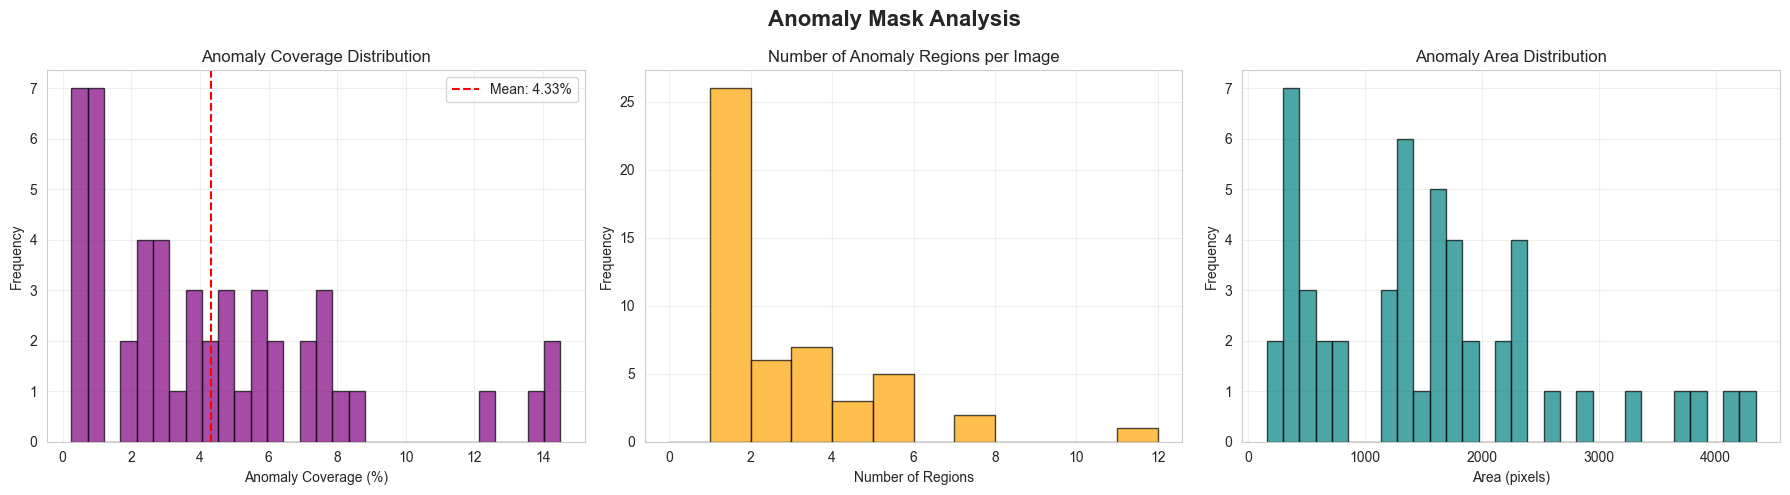


📏 Anomaly Size Categories:
   Small (<5%):     33 images (66.0%)
   Medium (5-20%):  17 images (34.0%)
   Large (≥20%):    0 images (0.0%)


In [12]:
# Visualize mask analysis
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('Anomaly Mask Analysis', fontsize=16, fontweight='bold')

# Anomaly coverage percentage
axes[0].hist(mask_analysis['percentages'], bins=30, color='purple', alpha=0.7, edgecolor='black')
axes[0].set_title('Anomaly Coverage Distribution')
axes[0].set_xlabel('Anomaly Coverage (%)')
axes[0].set_ylabel('Frequency')
axes[0].axvline(np.mean(mask_analysis['percentages']), color='red', linestyle='--', 
                label=f'Mean: {np.mean(mask_analysis["percentages"]):.2f}%')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Number of anomaly regions
axes[1].hist(mask_analysis['components'], bins=range(0, max(mask_analysis['components'])+2), 
             color='orange', alpha=0.7, edgecolor='black')
axes[1].set_title('Number of Anomaly Regions per Image')
axes[1].set_xlabel('Number of Regions')
axes[1].set_ylabel('Frequency')
axes[1].grid(alpha=0.3)

# Anomaly area (pixels)
axes[2].hist(mask_analysis['areas'], bins=30, color='teal', alpha=0.7, edgecolor='black')
axes[2].set_title('Anomaly Area Distribution')
axes[2].set_xlabel('Area (pixels)')
axes[2].set_ylabel('Frequency')
axes[2].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Categorize anomalies by size
small_anomalies = sum(1 for p in mask_analysis['percentages'] if p < 5)
medium_anomalies = sum(1 for p in mask_analysis['percentages'] if 5 <= p < 20)
large_anomalies = sum(1 for p in mask_analysis['percentages'] if p >= 20)

print("\n📏 Anomaly Size Categories:")
print(f"   Small (<5%):     {small_anomalies} images ({small_anomalies/len(mask_analysis['percentages'])*100:.1f}%)")
print(f"   Medium (5-20%):  {medium_anomalies} images ({medium_anomalies/len(mask_analysis['percentages'])*100:.1f}%)")
print(f"   Large (≥20%):    {large_anomalies} images ({large_anomalies/len(mask_analysis['percentages'])*100:.1f}%)")

## 7. Comprehensive Summary & Key Insights

In [13]:
print("=" * 100)
print("                           COMPREHENSIVE EDA INSIGHTS SUMMARY                              ")
print("=" * 100)

print("\n📊 DATASET COMPOSITION")
print("-" * 100)
print(f"✓ Total Images: {len(good_files) + len(bad_files):,}")
print(f"✓ Good (Normal) Samples: {len(good_files):,} ({good_ratio:.1f}%)")
print(f"✓ Bad (Anomaly) Samples: {len(bad_files):,} ({bad_ratio:.1f}%)")
print(f"✓ Anomaly Masks: {len(mask_files):,}")
print(f"✓ Class Balance: {'⚠️ Highly Imbalanced' if abs(good_ratio - bad_ratio) > 40 else '✅ Reasonably Balanced'}")

print("\n📅 TEMPORAL COVERAGE")
print("-" * 100)
if good_timestamps and bad_timestamps:
    print(f"✓ Data Collection Period: August - September 2024")
    print(f"✓ Good Samples: {min(good_timestamps)[:10]} to {max(good_timestamps)[:10]}")
    print(f"✓ Bad Samples: {min(bad_timestamps)[:10]} to {max(bad_timestamps)[:10]}")
    print(f"✓ Timestamp Precision: Microsecond-level (suitable for time-series analysis)")

print("\n🖼️  IMAGE CHARACTERISTICS")
print("-" * 100)
print(f"✓ Image Type: {list(good_type_counts.keys())[0] if good_type_counts else 'N/A'}")
print(f"✓ File Format: PNG")
print(f"✓ Avg Dimensions: {df_props.iloc[0]['Avg Width']:.0f} × {df_props.iloc[0]['Avg Height']:.0f} pixels")
print(f"✓ Color Channels: {df_props.iloc[0]['Avg Channels']:.0f} (RGB)")
print(f"✓ Avg File Size: {df_props.iloc[0]['Avg File Size (KB)']:.2f} KB")
print(f"✓ Aspect Ratio: {df_props.iloc[0]['Avg Aspect Ratio']:.2f}:1")

print("\n🎨 PIXEL INTENSITY PATTERNS")
print("-" * 100)
good_mean = intensity_comparison.iloc[0]['Avg Mean Intensity']
bad_mean = intensity_comparison.iloc[1]['Avg Mean Intensity']
intensity_diff = abs(good_mean - bad_mean)
print(f"✓ Good Images - Mean Intensity: {good_mean:.2f}")
print(f"✓ Bad Images - Mean Intensity: {bad_mean:.2f}")
print(f"✓ Intensity Difference: {intensity_diff:.2f} ({'Significant' if intensity_diff > 10 else 'Moderate'})")
print(f"✓ Standard Deviation:")
print(f"    - Good: {intensity_comparison.iloc[0]['Avg Std Dev']:.2f}")
print(f"    - Bad:  {intensity_comparison.iloc[1]['Avg Std Dev']:.2f}")

print("\n🌈 COLOR DISTRIBUTION")
print("-" * 100)
print(f"✓ RGB Channel Means (Good):")
print(f"    - Red:   {np.mean(good_r):.2f}")
print(f"    - Green: {np.mean(good_g):.2f}")
print(f"    - Blue:  {np.mean(good_b):.2f}")
print(f"✓ RGB Channel Means (Bad):")
print(f"    - Red:   {np.mean(bad_r):.2f}")
print(f"    - Green: {np.mean(bad_g):.2f}")
print(f"    - Blue:  {np.mean(bad_b):.2f}")

print("\n🔍 ANOMALY CHARACTERISTICS")
print("-" * 100)
print(f"✓ Average Anomaly Coverage: {np.mean(mask_analysis['percentages']):.2f}%")
print(f"✓ Anomaly Coverage Range: {np.min(mask_analysis['percentages']):.2f}% - {np.max(mask_analysis['percentages']):.2f}%")
print(f"✓ Avg Anomaly Regions per Image: {np.mean(mask_analysis['components']):.1f}")
print(f"✓ Most Common Anomaly Count: {np.median(mask_analysis['components']):.0f} regions")
print(f"✓ Anomaly Size Distribution:")
print(f"    - Small (<5%):    {small_anomalies} images ({small_anomalies/len(mask_analysis['percentages'])*100:.1f}%)")
print(f"    - Medium (5-20%): {medium_anomalies} images ({medium_anomalies/len(mask_analysis['percentages'])*100:.1f}%)")
print(f"    - Large (≥20%):   {large_anomalies} images ({large_anomalies/len(mask_analysis['percentages'])*100:.1f}%)")

print("\n" + "=" * 100)

                           COMPREHENSIVE EDA INSIGHTS SUMMARY                              

📊 DATASET COMPOSITION
----------------------------------------------------------------------------------------------------
✓ Total Images: 5,180
✓ Good (Normal) Samples: 4,157 (80.3%)
✓ Bad (Anomaly) Samples: 1,023 (19.7%)
✓ Anomaly Masks: 1,023
✓ Class Balance: ⚠️ Highly Imbalanced

📅 TEMPORAL COVERAGE
----------------------------------------------------------------------------------------------------
✓ Data Collection Period: August - September 2024
✓ Good Samples: 2024-08-03 to 2024-10-14
✓ Bad Samples: 2024-08-03 to 2024-09-23
✓ Timestamp Precision: Microsecond-level (suitable for time-series analysis)

🖼️  IMAGE CHARACTERISTICS
----------------------------------------------------------------------------------------------------
✓ Image Type: classifier_input
✓ File Format: PNG
✓ Avg Dimensions: 286 × 141 pixels
✓ Color Channels: 3 (RGB)
✓ Avg File Size: 43.64 KB
✓ Aspect Ratio: 2.27:1

🎨 PI